In [1]:
pip install datasets

In [2]:
import torch
import torch.nn as nn

from torchvision.models import vgg19, VGG19_Weights

import torchvision.transforms as transforms
import torchvision.transforms.functional as functional
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from datasets import load_from_disk
from datasets import DatasetDict

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# # can mount using UI instead

# from google.colab import drive
# drive.mount('/content/drive/MyDrive/ECE1508/')

In [4]:
#  download dataset from hugging face
# wikiart_dataset = load_dataset('huggan/wikiart')

# load saved wikiart_small dataset
wikiart_dataset = load_from_disk('/content/drive/MyDrive/ECE1508/wikiart_small')

In [5]:
# # save dataset to disk
# wikiart_dataset.save_to_disk('wikiart')

In [6]:
class WikiArtDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        # # read image
        # image_path = self.dataset[idx]['image']
        # PIL_image = Image.open(image_path)

#         # convert PIL_image to tensor
#         tensor_image = transforms.ToTensor()(PIL_image)

        data_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

        # preprocess img using data_transforms
        # tensor_image = data_transforms(self.dataset[idx]['image']).unsqueeze(0)
        tensor_image = data_transforms(self.dataset[idx]['image'])

        # label = torch.tensor(self.dataset[idx]['style'], dtype=torch.long)
        label = torch.tensor(self.dataset[idx]['artist'], dtype=torch.long)
        return tensor_image, label

In [7]:
# split train / test / valid

train_testvalid = wikiart_dataset['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

# gather all train, test, valid into a single DatasetDict
wikiart_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})


In [8]:
# cast to WikiArtDataset object

wikiart_train_dataset = WikiArtDataset(wikiart_dataset['train'])
wikiart_test_dataset = WikiArtDataset(wikiart_dataset['test'])
wikiart_valid_dataset = WikiArtDataset(wikiart_dataset['valid'])

In [9]:
# dataloader

batch_size = 32

wikiart_trainloader = DataLoader(wikiart_train_dataset, batch_size=batch_size, shuffle=True)
wikiart_validloader = DataLoader(wikiart_valid_dataset, batch_size=batch_size, shuffle=True)
wikiart_testloader = DataLoader(wikiart_test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# validate model

def valid(model, loss_function, device):
    # we first move our model to the configured device
    model = model.to(device = device)

    # set model to evaluate mode
    model.eval()

    # we make sure we are not tracking gradient
    # gradient is used in training, we do not need it for validation
    with torch.no_grad():
        running_risk = 0
        running_corrects = 0
        accumulating_accuracy = 0.0

        # loop over validation mini-batches
        for i, (images, labels) in enumerate(wikiart_validloader):

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # statistics
            running_risk += loss.item()
            # running_corrects += torch.sum(preds == labels.data)
            accumulating_accuracy += (preds == labels.data).float().mean()

        # average validation risk and accuracy over the whole validation dataset
        valid_risk = running_risk/i
        valid_accuracy = accumulating_accuracy/i

    return valid_risk, valid_accuracy

In [11]:
# train model

def train(model, num_epochs, learning_rate, device):
    # we first move our model to the configured device
    model = model.to(device = device)

    # set loss
    loss_function = nn.CrossEntropyLoss()

    # Set optimizer with optimizer
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

    # Initiate the values
    train_risk = []
    valid_risk = []
    valid_accuracy = []

    for epoch in range(num_epochs):
        # training risk in one epoch
        # risk = 0
        running_risk = 0.0
        running_corrects = 0

        # set model to training mode
        model.train()

        # loop over training data
        for i, (images, labels) in enumerate(wikiart_trainloader):

            # move tensors to the configured device
            images = images.to(device = device)
            labels = labels.to(device = device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_risk += loss.item()
            running_corrects += torch.sum(preds == labels.data)


        # validate model after update by the optimizer
        risk_epoch, accuracy_epoch = valid(model, loss_function, device)

        # collect losses and accuracy
        train_risk.append(running_risk/i)
        valid_risk.append(risk_epoch)
        valid_accuracy.append(accuracy_epoch)

        # print a message every epoch
        print('Epoch', epoch+1, '/', num_epochs)
        print('Train Risk: ', running_risk/i)
        print('Valid Risk: ', risk_epoch)
        print('Valid Accuracy: ', accuracy_epoch)

    return model, train_risk, valid_risk, valid_accuracy

In [12]:
# load pre-trained VGG 19 model

model = vgg19(weights=VGG19_Weights.DEFAULT)

# modify the last layer for number of classes
# num_classes = 27 # 27 style classes in wikiart dataset

# num_classes = 129 # 129 artist classes in wikiart dataset
# model.classifier[6] = nn.Linear(4096, num_classes)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
# look at the pre-trained weights, to compare to after fine-tuning
# # desired depth layers to compute style/content losses :
# content_layers_default = ['conv_4']
# style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
#### TODO
# print('conv_1 weights: ', model.features[0].weight)
# print('conv_2 weights: ', model.features[2].weight)
# print('conv_3 weights: ', model.features[5].weight)
# print('conv_4 weights: ', model.features[7].weight)
# print('conv_4 weights: ', model.features[10].weight)

In [14]:
# set device

# if torch.backends.cuda.is_built():
#     device = "cuda"
# elif torch.has_mps:
#     device = "mps"
# else:
#     device = "cpu"

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")

Training on GPU


In [15]:
# run training to fine-tune model on wikiart dataset

num_classes = 129 # 129 artist classes in wikiart dataset

model.classifier = nn.Sequential(
  nn.Linear(25088, 4096),
  nn.ReLU(True),
  nn.Dropout(0.5),
  nn.Linear(4096, 4096),
  nn.ReLU(True),
  nn.Dropout(0.5),
  nn.Linear(4096, num_classes))

# freeze all layers' weights in the model
for param in model.parameters():  # get all the parameters of the model
  param.requires_grad = False  # layers won't be updated during training

for param in model.classifier.parameters():
  param.requires_grad = True # update all classifier layers

# # unfreeze weights of last two fully connected layers and output layer
# for param in model.classifier[0].parameters():
#     param.requires_grad = True  # will be updated during training
# for param in model.classifier[3].parameters():
#     param.requires_grad = True  # will be updated during training
# for param in model.classifier[6].parameters():
#     param.requires_grad = True  # will be updated during training
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# int_num_epochs = 8 # starts to overfit after 8 epochs, so stop here
int_num_epochs = 10
int_learning_rate=0.001
int_model, int_train_risk, int_valid_risk, int_valid_accuracy = train(model, int_num_epochs, int_learning_rate, device)

Epoch 1 / 10
Train Risk:  3.0473095918523856
Valid Risk:  3.043026156425476
Valid Accuracy:  tensor(0.5148, device='cuda:0')
Epoch 2 / 10
Train Risk:  2.6946323305515234
Valid Risk:  2.9493180179595946
Valid Accuracy:  tensor(0.5116, device='cuda:0')
Epoch 3 / 10
Train Risk:  2.4498090503251024
Valid Risk:  2.7428064250946047
Valid Accuracy:  tensor(0.5257, device='cuda:0')
Epoch 4 / 10
Train Risk:  2.1724570725351717
Valid Risk:  2.658314657211304
Valid Accuracy:  tensor(0.5409, device='cuda:0')
Epoch 5 / 10
Train Risk:  1.8847928240968677
Valid Risk:  2.6256932735443117
Valid Accuracy:  tensor(0.5271, device='cuda:0')


In [ ]:
# unfreeze all layers' weights in the model
for param in int_model.parameters():  # get all the parameters of the model
    param.requires_grad = True  # all layers will be updated during training

num_epochs = 10
learning_rate=0.00001 # drop learning rate down, because we don't want to deviate from the pre-trained weights TOO much
finetuned_model, train_risk, valid_risk, valid_accuracy = train(int_model, num_epochs, learning_rate, device)

In [ ]:
PATH = '/content/drive/MyDrive/ECE1508/finetuned_model_params-4.pt'

torch.save(finetuned_model.state_dict(), PATH)

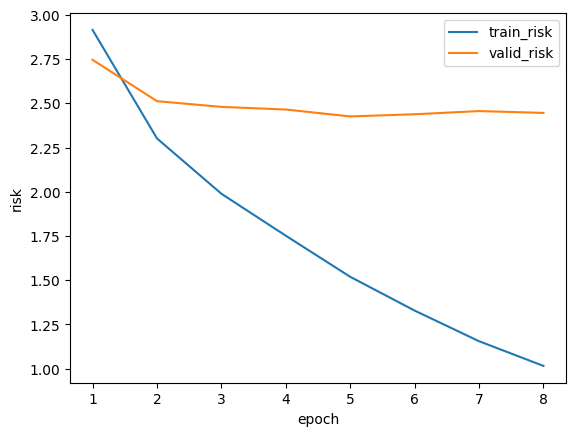

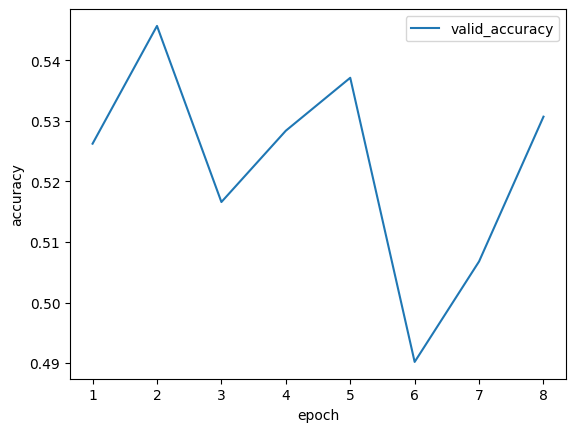

In [17]:
# plot the losses
plt.plot([i+1 for i in range(int_num_epochs)], int_train_risk, label='train_risk')
plt.plot([i+1 for i in range(int_num_epochs)], int_valid_risk, label='valid_risk')
plt.xlabel('epoch')
plt.ylabel('risk')
plt.legend()
plt.show()

# plot the accuracy
plt.plot([i+1 for i in range(int_num_epochs)], [item.cpu().numpy() for item in int_valid_accuracy], label='valid_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

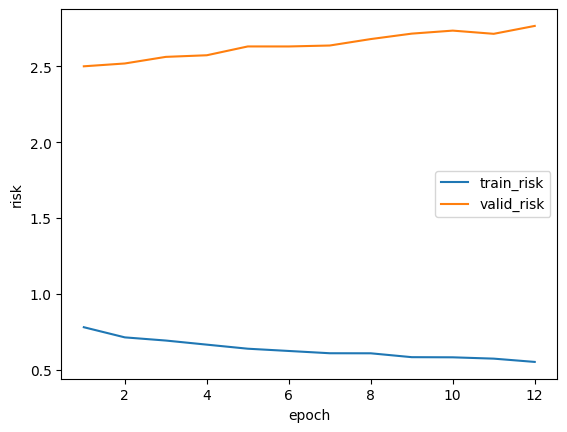

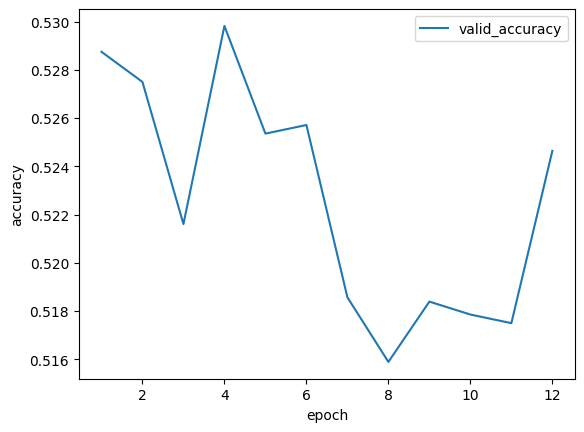

In [18]:
# plot the losses
plt.plot([i+1 for i in range(num_epochs)], train_risk, label='train_risk')
plt.plot([i+1 for i in range(num_epochs)], valid_risk, label='valid_risk')
plt.xlabel('epoch')
plt.ylabel('risk')
plt.legend()
plt.show()

# plot the accuracy
plt.plot([i+1 for i in range(num_epochs)], [item.cpu().numpy() for item in valid_accuracy], label='valid_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [30]:
def show_img(img):

    img = img.cpu().clone()  # clone image
    img = img.squeeze(0)

    # convert tensor image to PIL
    PIL_img = functional.to_pil_image(img)

    # show image
    plt.imshow(PIL_img)
    plt.show()


In [32]:
wikiart_train_dataset[0][0]

tensor([[[-1.4672, -1.5357, -1.5528,  ..., -1.5185, -1.5185, -1.5014],
         [-1.5357, -1.5699, -1.5699,  ..., -1.5528, -1.5870, -1.5870],
         [-1.5014, -1.5185, -1.4672,  ..., -1.5357, -1.5870, -1.5870],
         ...,
         [-1.6042, -1.5528, -1.4843,  ..., -1.6042, -1.5014, -1.4158],
         [-1.5699, -1.5528, -1.5357,  ..., -1.5699, -1.4843, -1.3815],
         [-1.5014, -1.4843, -1.5014,  ..., -1.4672, -1.3987, -1.2959]],

        [[-1.3704, -1.4405, -1.4580,  ..., -1.4230, -1.4055, -1.3880],
         [-1.4405, -1.4755, -1.4755,  ..., -1.4405, -1.4755, -1.4755],
         [-1.4055, -1.4230, -1.3704,  ..., -1.4230, -1.4755, -1.4755],
         ...,
         [-1.5105, -1.4580, -1.3880,  ..., -1.5105, -1.4055, -1.3354],
         [-1.4755, -1.4580, -1.4405,  ..., -1.4755, -1.3880, -1.3004],
         [-1.4055, -1.4055, -1.4055,  ..., -1.3704, -1.3004, -1.1954]],

        [[-1.1421, -1.2119, -1.2293,  ..., -1.2641, -1.2641, -1.2467],
         [-1.2119, -1.2467, -1.2467,  ..., -1

In [36]:
wikiart_train_dataset[0][0].shape

torch.Size([3, 128, 128])

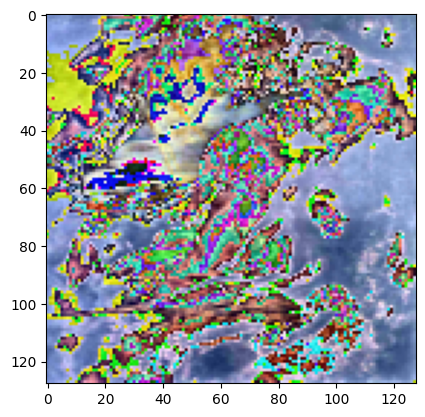

In [33]:
show_img(wikiart_train_dataset[0][0])

In [35]:
y_pred = finetuned_model(wikiart_train_dataset[0][0].to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x49 and 25088x4096)

In [48]:
running_corrects = 0.0
accumulating_accuracy = 0.0

for i, (images, labels) in enumerate(wikiart_validloader):

  # move tensors to the configured device
  images = images.to(device = device)
  labels = labels.to(device = device)

  # forward pass
  outputs = finetuned_model(images)
  _, preds = torch.max(outputs, 1)

  running_corrects += torch.sum(preds == labels.data)

  acc_all = (preds == labels).float().mean()

  accumulating_accuracy += (preds == labels.data).float().mean()

  print('preds: ', preds)
  print('labels: ', labels)
  print('running corrects: ', running_corrects)
  print('acc_all: ', acc_all)

  print('accumulating_accuracy: ', accumulating_accuracy)




preds:  tensor([ 7, 12, 12, 20, 20, 20,  3,  4, 21, 20, 12, 26, 17, 20, 10, 21, 13,  0,
        12,  7, 21, 21,  3, 12, 23, 19, 23, 14,  9, 20,  9,  0, 24, 21,  4, 23,
        12, 21, 10, 24, 12,  9, 14, 20, 23, 12, 13,  9, 21,  0, 22, 21, 23,  4,
        21,  4, 15, 21, 21, 22, 21, 26, 21, 12], device='cuda:0')
labels:  tensor([13, 12,  9, 20, 15,  9, 26,  4,  9, 23, 12, 20, 16, 20, 24, 20, 13,  0,
        20,  2, 23, 11,  3, 12, 23, 15,  9,  5, 15, 21, 21,  9, 23, 21, 23, 23,
        21, 21, 19,  7, 12, 20, 14,  9, 24, 12, 17,  9, 23,  9, 22, 21, 24,  4,
        23,  4,  9, 21, 21, 22,  9, 20, 21, 15], device='cuda:0')
running corrects:  tensor(25., device='cuda:0')
acc_all:  tensor(0.3906, device='cuda:0')
accumulating_accuracy:  tensor(0.3906, device='cuda:0')
preds:  tensor([12,  5, 12, 21,  7, 21,  9,  4, 12, 23, 20, 24,  3, 12, 22, 21, 26,  3,
        23,  4,  9,  7, 21, 21, 12,  0, 12, 23,  9, 23,  4,  3, 12, 12,  9, 20,
        14, 21, 22,  0,  7, 23, 21,  9, 19, 10, 21, 12, 2

In [49]:
valid_accuracy = running_corrects/i
print('running corrects: ', running_corrects)
print('i: ', i)
print('valid_accuracy: ', valid_accuracy)


running corrects:  tensor(329., device='cuda:0')
i:  12
valid_accuracy:  tensor(27.4167, device='cuda:0')


In [50]:

accumulating_accuracy / i

tensor(0.4370, device='cuda:0')